### VGG16 Image Captioning.

### Imports

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

import os, time, sys
from PIL import Image

from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.__version__

'2.6.0'

### Mounting the drive

We are going to load the data and their annotations from google drive. So we need to mount the drive.

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path = "/content/drive/My Drive/image-captioning/coco"
os.listdir(base_path)

['annotations_trainval2017.zip',
 'val2017.zip',
 'data_urls.txt',
 'annotations',
 'val2017']

### Extracting zip files

In [4]:
import zipfile

# annotations
with zipfile.ZipFile(os.path.join(base_path, 'annotations_trainval2017.zip'), "r") as z:
  z.extractall(base_path)

# annotations
with zipfile.ZipFile(os.path.join(base_path, 'val2017.zip'), "r") as z:
  z.extractall(base_path)

print("Done")

Done


In [5]:
import json

In [6]:
def load_records():
  path = os.path.join(base_path, 
                      "annotations", "captions_val2017.json")
  
  with open(path, "r", encoding="utf-8") as file:
        data_raw = json.load(file)

  images = data_raw['images']
  annotations = data_raw['annotations']

  records = dict()
  for image in images:
    
    record = dict()
    record["filename"] = image["file_name"]
    record["id"] = image["id"]

    record["captions"] = list()

    records[image["id"]] = record

  for annotation in annotations:
    record = records[annotation['image_id']]
    record['captions'].append(annotation.get("caption"))

  records_list = [(key, record['filename'], record['captions'])
                    for key, record in sorted(records.items())]
  ids, filenames, captions = zip(*records_list)
  return ids, filenames, captions

ids, filenames, captions = load_records()

In [7]:
filenames[:2], ids[:2], captions[:2]

(('000000000139.jpg', '000000000285.jpg'),
 (139, 285),
 (['A woman stands in the dining area at the table.',
   'A room with chairs, a table, and a woman in it.',
   'A woman standing in a kitchen by a window',
   'A person standing at a table in a room.',
   'A living area with a television and a table'],
  ['A big burly grizzly bear is show with grass in the background.',
   'The large brown bear has a black nose.',
   'Closeup of a brown bear sitting in a grassy area.',
   'A large bear that is sitting on grass. ',
   "A close up picture of a brown bear's face."]))

### Get names and captions

In [8]:
_, image_names, captions = load_records()

### Counting examples

In [9]:
num_images = len(image_names)
num_images

5000

As you can see we only have ``5000`` images in this dataset, you can use the train set which contains a lot of training examples.

### Helper functions

We are going to define helper functions that will do the following:

1. loading images
2. display images

In [10]:
def load_image(path, size=(224, 224)): # vgg16 size
  image = Image.open(path)
  if not size is  None:
    image = image.resize(size=size, resample=Image.LANCZOS)

  image = np.array(image, dtype=np.float32)
  image = image/255.0

  # gray scale image to a 3-dim RGB array
  if (len(image.shape) == 2):
    image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
  return  image

In [11]:
def show_image(index):
  assert index < num_images - 1, f"recieved index {index} for index range [0, {num_images}]"

  # path to images 
  img_dirs = os.path.join(base_path, "val2017")
  file_name = image_names[index]
  caps = captions[index]

  for caption in caps:
    print(caption)

  image = load_image(os.path.join(img_dirs, file_name))
  plt.imshow(image)
  plt.show()

### Displaying sample examples.

A beautiful woman taking a picture with her smart phone.
People underneath an arched bridge near the water.
A girl is taking a picture of people fishing.
The woman is taking a photo of the white goose next to the river.
A waterway under a bridge with people sitting down and a woman taking a photo.


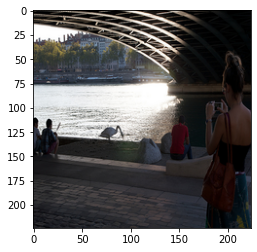

In [12]:
show_image(10)

A woman stands in the dining area at the table.
A room with chairs, a table, and a woman in it.
A woman standing in a kitchen by a window
A person standing at a table in a room.
A living area with a television and a table


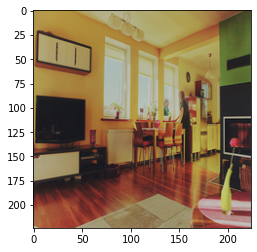

In [13]:
show_image(0)

An adult elephant is pictured walking with a baby elephant.
A baby elephant walks with an older elephant
A baby elephant walks between the legs of its mother.
A baby elephant walking along the same path as its mother. 
a bunch of elephants are standing together in a pin


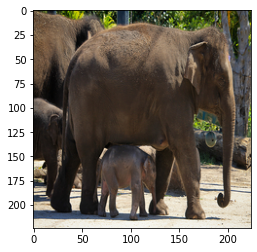

In [14]:
show_image(500)

### Closer look to the dataset.

Our dataset contains an image that has more than one caption. We want to create a function that takes an index of an image and generates the same image with a single caption in the caption list.

In [15]:
def expand_dataset(index):
  img_dirs = os.path.join(base_path, "val2017")
  file_name = image_names[index]
  caps = captions[index]
  image = load_image(os.path.join(img_dirs, file_name))
  images_to_captions = []
  for caption in caps:
    images_to_captions.append([image, caption])
  return images_to_captions

In [16]:
sample = expand_dataset(0)
len(sample)

5

In [17]:
def display_sample(index):
  img, cap = sample[index]
  print(cap)
  plt.imshow(img)
  plt.show()

A woman stands in the dining area at the table.


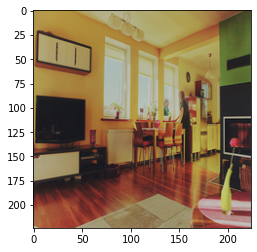

A room with chairs, a table, and a woman in it.


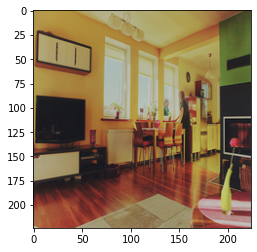

In [18]:
for i in range(2):
  display_sample(i)

### Expanding the dataset.

We want to pair each image with it's caption.

In [19]:
images_captions = []
for i in range(int(num_images * .7)):
  images_captions.extend(expand_dataset(i))

In [20]:
len(images_captions)

17509

### Randomly shuffling the images to captions pairs.

In [21]:
import random

In [22]:
random.shuffle(images_captions)

In [23]:
def display_sample(index):
  img, cap = images_captions[index]
  print(cap)
  plt.imshow(img)
  plt.show()

Three images of the same man hitting a tennis ball


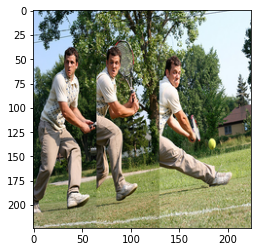

Man with a backpack carrying his dog in the pouch.


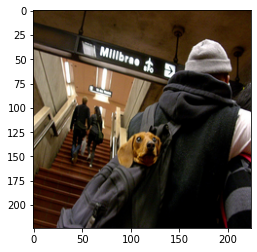

In [24]:
for i in range(2):
  display_sample(i)

### Text preprocessing

We are going to use the Tokenizer from keras to preprocess the text into vectors of integers.

In [25]:
captions = []
for _, cap in images_captions:
  captions.append(f"<start> {cap} <end>")

In [26]:
captions[:2]

['<start> Three images of the same man hitting a tennis ball <end>',
 '<start> Man with a backpack carrying his dog in the pouch. <end>']

In [27]:
num_words = 10_000

In [28]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words,
                                                  oov_token="<unk>",
                                                 )
tokenizer.fit_on_texts(captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

### Converting text to integers

In [29]:
token_captions = tokenizer.texts_to_sequences(captions)

In [30]:
token_captions[:2]

[[4, 77, 1161, 6, 7, 668, 13, 508, 2, 29, 76, 3],
 [4, 13, 9, 2, 1426, 422, 45, 49, 8, 7, 2726, 3]]

### Padding the sequences

In [31]:
token_captions_padded = pad_sequences(
    token_captions, maxlen=20, 
    padding='post', truncating='post'
)

In [32]:
token_captions_padded[:2]

array([[   4,   77, 1161,    6,    7,  668,   13,  508,    2,   29,   76,
           3,    0,    0,    0,    0,    0,    0,    0,    0],
       [   4,   13,    9,    2, 1426,  422,   45,   49,    8,    7, 2726,
           3,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

> Now we need to map captions tokens with their respective images vector.


Our image should be preprocessed 

In [33]:
images = []
for image, _ in images_captions:
  images.append(image)

In [35]:
assert len(images) == len(token_captions_padded), "images and captions must have the same length"

### Creating the dataset.

We are going to create the dataset using the `tf.data.Dataset.from_tensor_slice`.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(
    (images, token_captions_padded)
)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
dataset = dataset.shuffle(BUFFER_SIZE
                          ).batch(BATCH_SIZE
                                  ).prefetch(
                                      buffer_size=tf.data.AUTOTUNE)

### Building the model.

We are going to build our end to end

### The VGG16 model

We are going to use transfare learnig (fine tunning) to us the VGG16 model to perform image classification.

> If ``include_top=True`` then the whole VGG16 model is downloaded which is about 528 MB. If ``include_top=False`` then only the convolutional part of the VGG16 model is downloaded which is just ``57 MB``.

We are going to download the whole model.

In [17]:
image_model = VGG16(include_top=True, weights='imagenet')
image_model.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

We are going to use all the layers of the models up from the top up to ``fc2`` layer. we are not interested in the ``prediction`` layer.

In [18]:
transfare_layer = image_model.get_layer("fc2")
transfare_layer

We called it the "transfer-layer" because we will transfer its output to another model that creates the image captions.

To do this, first we need to create a new model which has the same input as the original ``VGG16`` model but outputs the transfer-values from the ``fc2`` layer.

In [ ]:
image_model_transfare = keras.Model(
  inputs=image_model.input, outputs = transfare_layer.output,
  name= "image_model_transfare" 
)
image_model_transfare.summary()

### Getting the size of the image.

We are now going to get the shape of the image that `VGG16` accept as follows

In [ ]:
image_size = K.int_shape(image_model.input)[1:3]
image_size

For each input image, the new model will output a vector of transfer-values with the following length.

In [ ]:
class BahdanauAttention(keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = keras.layers.Dense(units)
    self.W2 = keras.layers.Dense(units)
    self.V = keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(keras.Model):
  def __init__(self, embedding_dim, vgg16):
    super(CNN_Encoder, self).__init__()
    self.fc = keras.layers.Dense(embedding_dim)
    self.vgg16 = vgg16

  def call(self, x):
    x = self.vgg16(x)
    x = self.fc(x)
    x = tf.nn.relu(x)
    return x

In [ ]:
class RNN_Decoder(keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = keras.layers.Dense(self.units)
    self.fc2 = keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
embedding_dim = 100
encoder = CNN_Encoder(embedding_dim)

In [ ]:
encoder = CNN_Encoder(embedding_dim)